<a href="https://colab.research.google.com/github/infiniteloop0048/scRNAseq/blob/main/Clustering_SingleCell_data_with_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install packages**

In [1]:
!pip install -q torch
!pip install scanpy
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.1 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=3588873ce1a146eaeb10a51a25b10c462d237034ebcbe3429ce2ebb311b21ae8
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info
Looking in links: https://data.pyg.org/whl/torch-.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linu

**Import Packages**

In [2]:
import scanpy as sc
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

import os
import torch
os.environ['TORCH'] = torch.__version__
os.environ['PYTHONWARNINGS'] = "ignore"

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

from sklearn import preprocessing
import scanpy as sc

import anndata

# import torch
import torch.nn as nn
import torch.optim as optim
# from torch_geometric.nn import GCNConv


from collections import Counter

**Connect to drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


File Read

In [4]:
class Read_File:
    def __init__(self, file_path):
        self.file_path = file_path

    def getFilePath(self):
        return self.file_path

    def readFileRetDF(self):
        df = pd.read_csv(self.file_path)
        return df

    def readFileByScanpy(self):
        adata = sc.read(self.file_path)
        adata = adata.T
        return adata


In [28]:
class FineTune:

    # def __init__(self, df):
    #     self.df = df

    def makeCellByGeneFile(self, df):
        df = df.drop(df.columns[0], axis=1) # removing gene names
        df = df.T # making cell * genes
        num_of_genes = df.shape[1]
        return df, num_of_genes

    def normalize(self, df):
        df = preprocessing.normalize(df)
        # df = np.log1p(df)
        df = pd.DataFrame(df)
        return df

    def findHVG(self, df, num_of_genes):
        adata = anndata.AnnData(df)
        n_top_genes = 10000
        if num_of_genes >= 10000:
            n_top_genes = 10000
        else:
            n_top_genes = num_of_genes

        print(f'top genes - {n_top_genes} total genes - {num_of_genes}')

        sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, min_mean=0.0125, max_mean=3)
        highly_variable_genes = adata.var['highly_variable']
        # print(highly_variable_genes)
        df = df.loc[:, highly_variable_genes.values]
        return df

    # def PCA(self, n_components):
    #     pca = PCA(n_components=n_components)
    #     pca.fit(self.df)
    #     pca_features = pca.transform(self.df)
    #     return pca_features

    def PCA_for_divided_data(self, df, start, end, n_components):
        pca = PCA(n_components=n_components)
        pca.fit(df.iloc[:, start:end])
        pca_features = pca.transform(df.iloc[:, start:end])
        return pca_features

    def PCA4(self, df, num_of_genes, n_components, number_of_division):

        pca_features_all = []
        current_genes = 10000
        if num_of_genes >= 10000:
            current_genes = 10000
        else:
            current_genes = num_of_genes
        ranze_size = (int)(current_genes / number_of_division)

        for i in range(0, current_genes, ranze_size):

            if i + ranze_size > current_genes:
                break
            pca_features_all.append(self.PCA_for_divided_data(df, i, i + ranze_size, n_components))
            print(i, i + ranze_size)

        # pca_features1 = self.PCA_for_divided_data(0, 2500, n_components)
        # pca_features2 = self.PCA_for_divided_data(2500, 5000, n_components)
        # pca_features3 = self.PCA_for_divided_data(5000, 7500, n_components)
        # pca_features4 = self.PCA_for_divided_data(7500, 10000, n_components)
        # pca = PCA(n_components=n_components)
        # pca.fit(self.df.iloc[:, :2500])
        # pca_features1 = pca.transform(self.df.iloc[:, :2500])


        # return pca_features1, pca_features2, pca_features3, pca_features4
        return pca_features_all

    def performTuning(self, df):
        df, num_of_genes = self.makeCellByGeneFile(df)
        df = self.normalize(df)
        df = self.findHVG(df, num_of_genes)
        return df, num_of_genes


    def performPCA(self, df, num_of_genes, n_components, number_of_division):
        # self.makeCellByGeneFile()
        # self.normalize()
        # self.findHVG()
        pca_features_all = self.PCA4(df, num_of_genes, n_components, number_of_division)



        # pca_features_all = fTune.performAllTuning4(n_components = n_components, number_of_division = number_of_division)
        pca_features_final = pca_features_all[number_of_division - 1]
        for i in range(number_of_division - 1):
            pca_features_final = pca_features_final + pca_features_all[i]

        pca_features_final = pca_features_final / number_of_division




        return pca_features_final


    # def makeCellByGeneFile(self, df):
    #     df = df.drop(df.columns[0], axis=1) # removing gene names
    #     df = df.T # making cell * genes
    #     return df

    # def normalize(self, df):
    #     df = preprocessing.normalize(df)
    #     # df = np.log1p(df)
    #     df = pd.DataFrame(df)
    #     return df

    # def findHVG(self, df):
    #     adata = anndata.AnnData(df)
    #     sc.pp.highly_variable_genes(adata, n_top_genes=10000, min_mean=0.0125, max_mean=3)
    #     highly_variable_genes = adata.var['highly_variable']
    #     df = df.loc[:, highly_variable_genes.values]
    #     return df

    # def PCA(self, df, n_components):
    #     pca = PCA(n_components=n_components)
    #     pca.fit(df)
    #     pca_features = pca.transform(df)
    #     return pca_features


In [6]:
class Graph:
    def __init__(self, node_feats):
        self.node_feats = node_feats
        self.edge_index = []
        self.edge_weight = []

    def setEdgeIndexAndWeight(self, pca_features):
        for i in range(pca_features.shape[0]):
          for j in range(i + 1, pca_features.shape[0]):
            self.edge_index.append([i, j])
            self.edge_weight.append(np.sqrt(np.power(pca_features[i][0] - pca_features[j][0], 2) + np.power(pca_features[i][1] - pca_features[j][1], 2)))

    def numberOfNodes(self):
        return self.node_feats.shape[0]

    def numberOfFeats(self):
        return self.node_feats.shape[1]

    def convertToTensorObj(self):
        self.node_feats = torch.tensor(self.node_feats.values).float()
        self.edge_index = torch.tensor(self.edge_index)
        self.edge_weight = torch.tensor(self.edge_weight)


In [7]:
class GNN(torch.nn.Module):
    def __init__(self, num_node_features, num_clusters, hidden_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_clusters)

    def forward(self, g):

        x = g.node_feats
        edge_index = g.edge_index.T
        edge_weight = g.edge_weight.float()

        x = self.conv1(x, edge_index, edge_weight)
        x = x.relu()
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)

        # Use softmax for the clustering assignment
        x = F.log_softmax(x, dim=1)

        return x

In [8]:
class Plot:
      def scatterPlot(self, pca_features, out):
          plt.scatter(pca_features[:, 0], pca_features[:, 1], c=out.argmax(dim=1))
          plt.show()
      def scatterplotPCA(self, pca_features):
          plt.scatter(pca_features[:, 0], pca_features[:, 1])
          plt.show()

In [9]:
class Execute:
      def __init__(self, model, g):
          self.model = model
          self.g = g

      def runModel(self):
          out = model(g)
          return out

In [10]:
def constructGraph(node_feats, pca_features):
    g = Graph(node_feats = node_feats)
    g.setEdgeIndexAndWeight(pca_features = pca_features)
    return g

**KMEANS**

In [11]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

In [22]:
class KMEANS:
    def __init__(self, f_Tune, ground_truth):
        self.f_Tune = f_Tune
        self.ground_truth = ground_truth

    def performKmeans(self, pca_features_final, n_clusters):
        # pca_features_all = fTune.performAllTuning4(n_components = n_components, number_of_division = number_of_division)
        # self.pca_features_final = pca_features_all[number_of_division - 1]
        # for i in range(number_of_division - 1):
        #     self.pca_features_final = self.pca_features_final + pca_features_all[i]

        # self.pca_features_final = self.pca_features_final / number_of_division
        # self.number_of_division = number_of_division

        # print('ehane ase?')

        # X = pca_features_final

        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(pca_features_final)

        print(pca_features_final.shape)

        #get the centroids
        centroids = kmeans.cluster_centers_
        labels = kmeans.labels_
        # print(f'label counts {len(self.labels)} --- ground_truth {len(self.ground_truth)}')
        ARI = metrics.adjusted_rand_score(list(labels), ground_truth)
        print(f'ari - {ARI}')

        return ARI, labels
        #get the ARI



        # print(np.bincount(self.labels))
        # sorted_data_count_each_cluster = np.sort(np.bincount(self.labels))
        # self.error = np.sum(np.abs(sorted_data_count_each_cluster - self.ground_truth))


    def plot(self, pca_features_final, data_name, number_of_division, ARI, labels):
        # colors = ["g.", "r.", "b.", "y."]
        # checking
        colors = ["g.", "r.", "b.", "y.", "c.", "m.", "k.", "w.", "g.", "r.", "b.", "y.", "c.", "m.", "k.", "w.", "g.", "r.", "b.", "y."]
        for i in range(len(pca_features_final)):
            plt.plot(pca_features_final[i][0], pca_features_final[i][1], colors[labels[i]], markersize=10)
        # plt.scatter(centroids[:,0], centroids[:,1], marker='x', s=150, linewidths=5)
        plt.xlabel('principle component 1')
        plt.ylabel('principle component 2')
        # accuracy based on ARI

        plt.title(f'ARI = {ARI}')
        # plt.plot()
        plt.savefig(f'/content/drive/MyDrive/Research/Bioinformatics/scRNAseq/datas/{data_name}/plot/division_{number_of_division}.png')
        plt.show()
        # plt.clf()
        # plt.close()



Just set the data name and col number where the cluster info is located in celldata


number of clusters 10
268


/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


top genes - 10000 total genes - 22431
0 10000
(268, 50)
ari - 0.39505426713426073


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


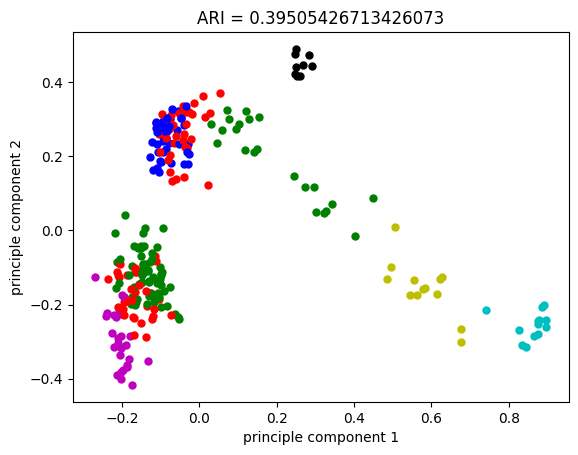

0 5000
5000 10000
(268, 50)
ari - 0.4216743825280431


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


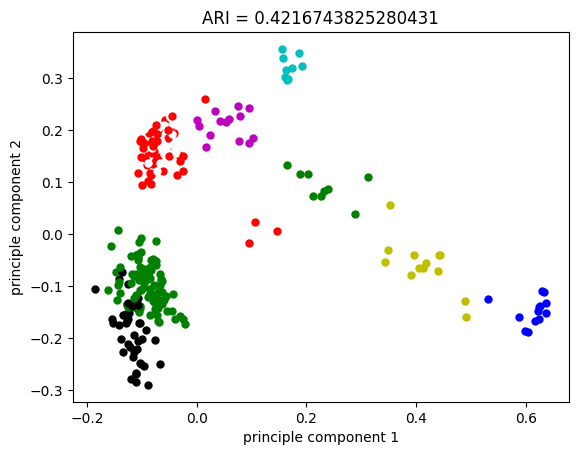

0 3333
3333 6666
6666 9999
(268, 50)
ari - 0.4536753918446163


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


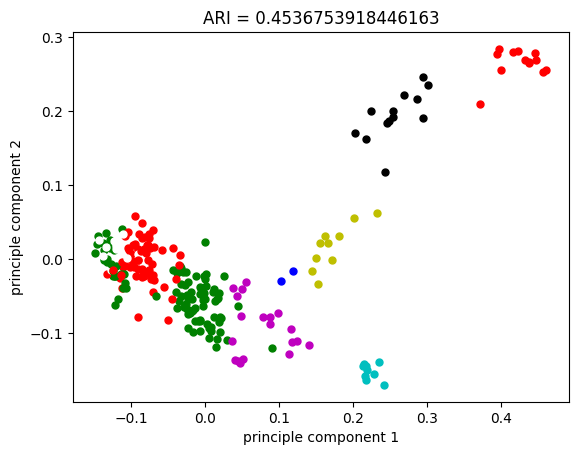

0 2500
2500 5000
5000 7500
7500 10000
(268, 50)
ari - 0.3410120755028783


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


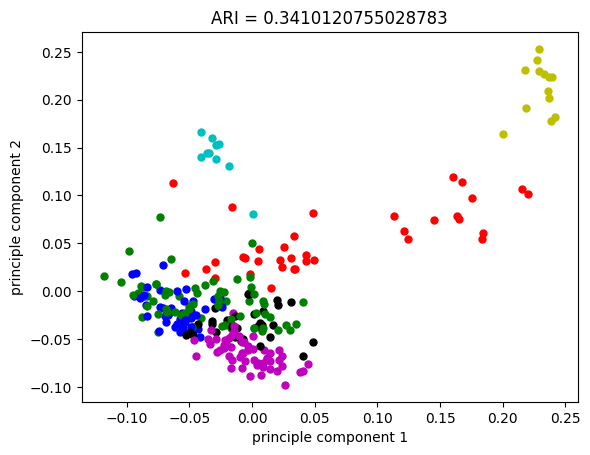

0 2000
2000 4000
4000 6000
6000 8000
8000 10000
(268, 50)
ari - 0.36581369716325357


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


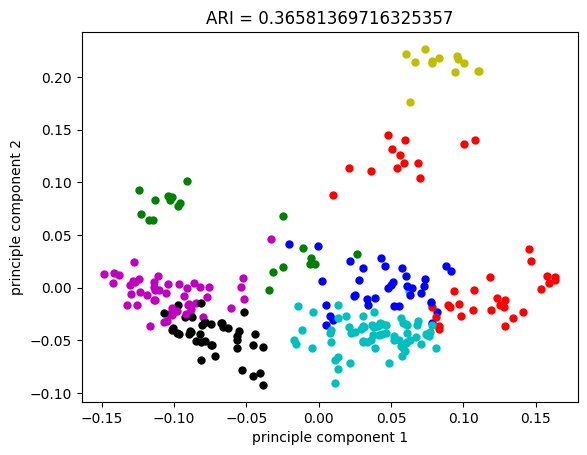

0 1666
1666 3332
3332 4998
4998 6664
6664 8330
8330 9996
(268, 50)
ari - 0.325295912871541


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


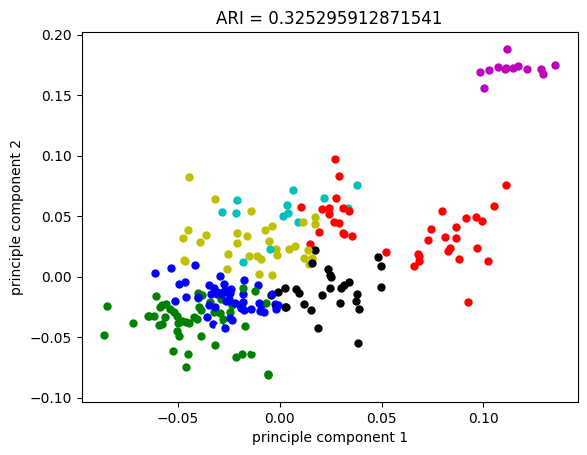

0 1428
1428 2856
2856 4284
4284 5712
5712 7140
7140 8568
8568 9996
(268, 50)
ari - 0.3229803274824008


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


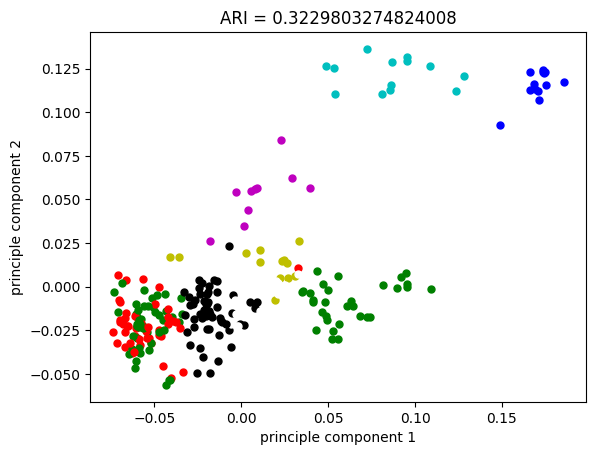

0 1250
1250 2500
2500 3750
3750 5000
5000 6250
6250 7500
7500 8750
8750 10000


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(268, 50)
ari - 0.28485000053493237


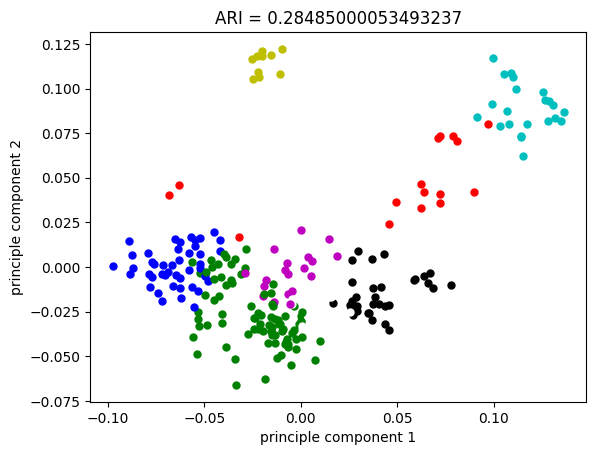

0 1111
1111 2222
2222 3333
3333 4444
4444 5555
5555 6666
6666 7777
7777 8888
8888 9999
(268, 50)
ari - 0.3218281996143006


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


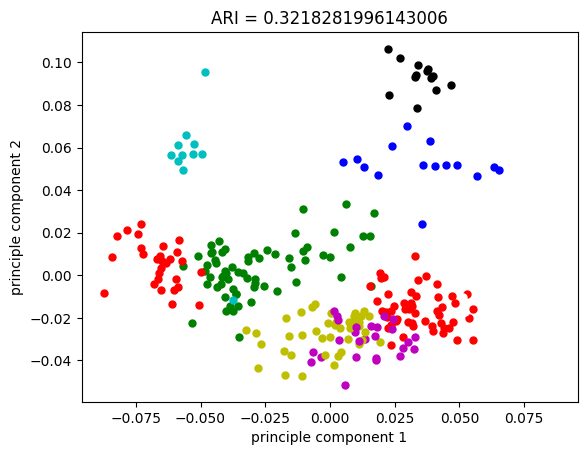

0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
(268, 50)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


ari - 0.3058134025663314


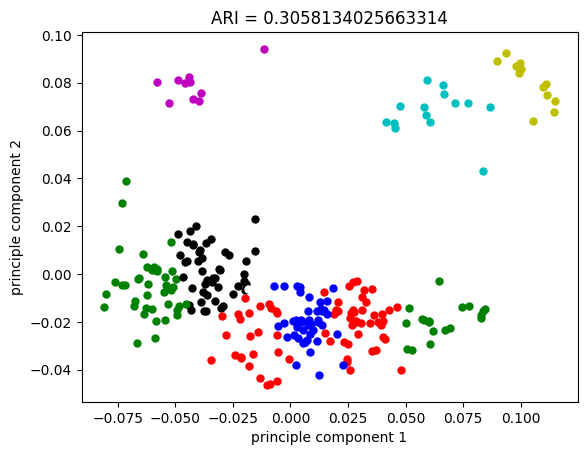

0 909
909 1818
1818 2727
2727 3636
3636 4545
4545 5454
5454 6363
6363 7272
7272 8181
8181 9090
9090 9999
(268, 50)
ari - 0.265903340499245


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


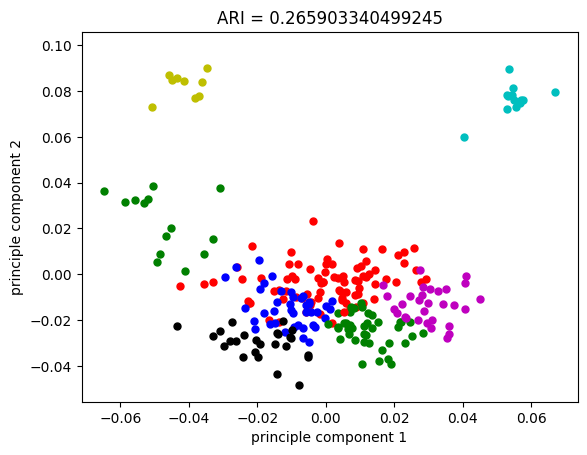

0 833
833 1666
1666 2499
2499 3332
3332 4165
4165 4998
4998 5831
5831 6664
6664 7497
7497 8330
8330 9163
9163 9996
(268, 50)
ari - 0.3230406196458617


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


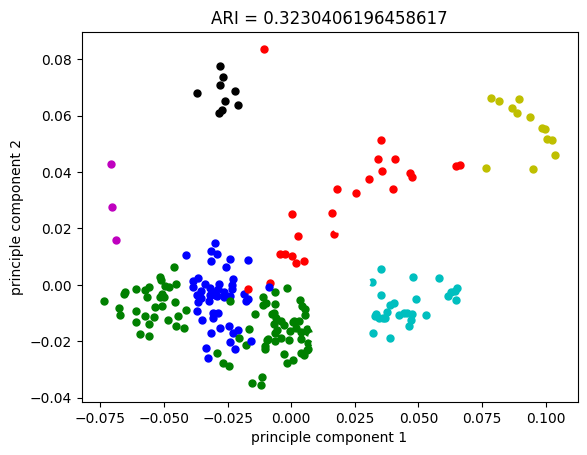

0 769
769 1538
1538 2307
2307 3076
3076 3845
3845 4614
4614 5383
5383 6152
6152 6921
6921 7690
7690 8459
8459 9228
9228 9997


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(268, 50)
ari - 0.26538568630873643


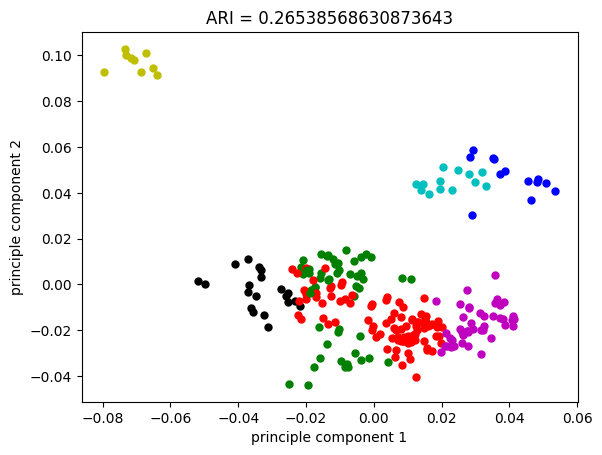

0 714
714 1428
1428 2142
2142 2856
2856 3570
3570 4284
4284 4998
4998 5712
5712 6426
6426 7140
7140 7854
7854 8568
8568 9282
9282 9996


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(268, 50)
ari - 0.29932670838426256


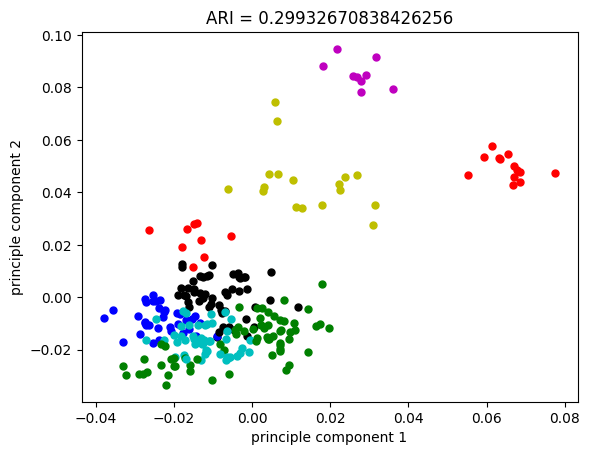

0 666
666 1332
1332 1998
1998 2664
2664 3330
3330 3996
3996 4662
4662 5328
5328 5994
5994 6660
6660 7326
7326 7992
7992 8658
8658 9324
9324 9990
(268, 50)
ari - 0.2742010058831324


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


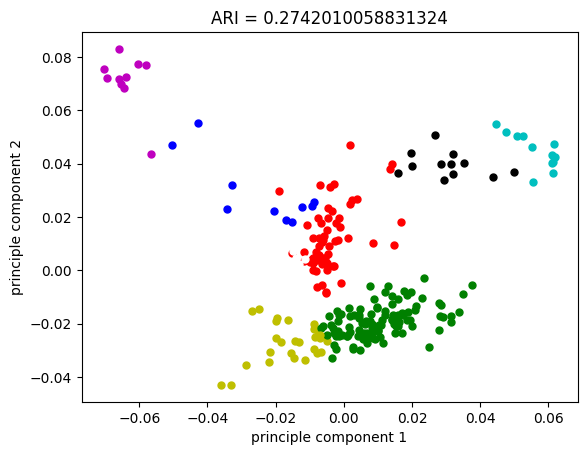

0 625
625 1250
1250 1875
1875 2500
2500 3125
3125 3750
3750 4375
4375 5000
5000 5625
5625 6250
6250 6875
6875 7500
7500 8125
8125 8750
8750 9375
9375 10000
(268, 50)
ari - 0.25960911640444073


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


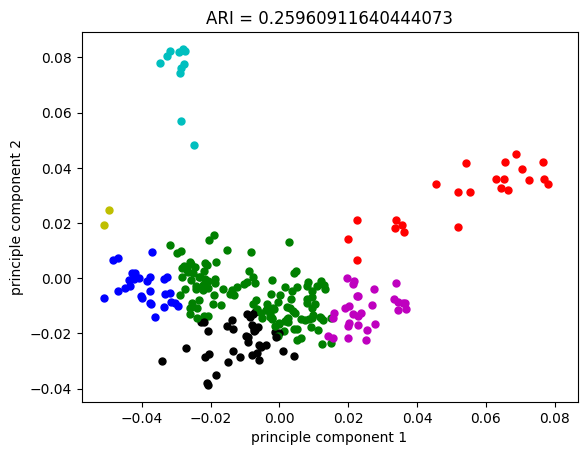

0 588
588 1176
1176 1764
1764 2352
2352 2940
2940 3528
3528 4116
4116 4704
4704 5292
5292 5880
5880 6468
6468 7056
7056 7644
7644 8232
8232 8820
8820 9408
9408 9996
(268, 50)
ari - 0.1125614530781979


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


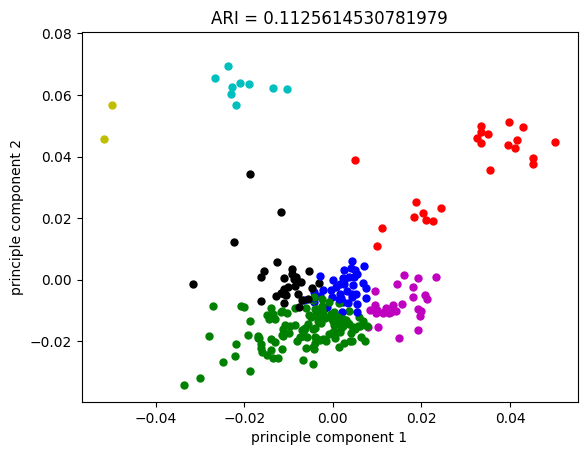

0 555
555 1110
1110 1665
1665 2220
2220 2775
2775 3330
3330 3885
3885 4440
4440 4995
4995 5550
5550 6105
6105 6660
6660 7215
7215 7770
7770 8325
8325 8880
8880 9435
9435 9990


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(268, 50)
ari - 0.24413791677489471


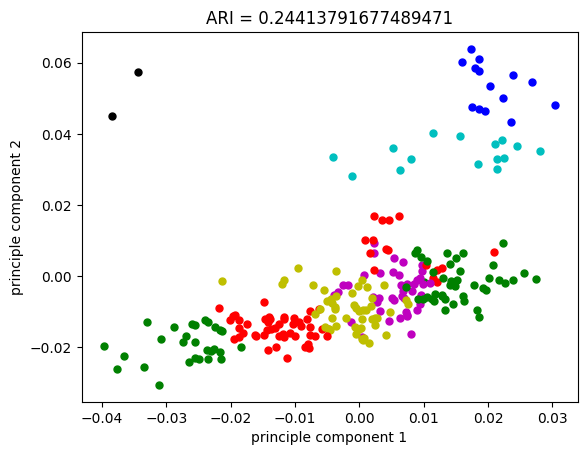

0 526
526 1052
1052 1578
1578 2104
2104 2630
2630 3156
3156 3682
3682 4208
4208 4734
4734 5260
5260 5786
5786 6312
6312 6838
6838 7364
7364 7890
7890 8416
8416 8942
8942 9468
9468 9994


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(268, 50)
ari - 0.18167181912351194


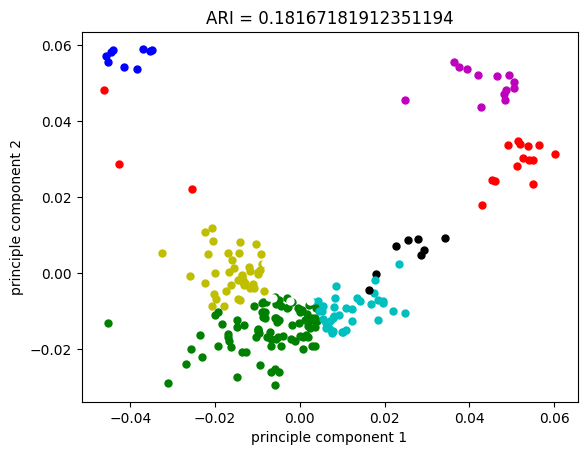

In [30]:
data_name = "deng-rpkms"
col_no_for_cluster_info = 1
n_components = 50

# file_path_data = f'/content/drive/MyDrive/Research/Bioinformatics/scRNAseq/datas/{data_name}/biase_data.csv'
# file_path_celldata = f'/content/drive/MyDrive/Research/Bioinformatics/scRNAseq/datas/{data_name}/biase_celldata.csv'

file_path_data = f'/content/drive/MyDrive/Research/Bioinformatics/scRNAseq/datas/{data_name}/{data_name}_data.csv'
file_path_celldata = f'/content/drive/MyDrive/Research/Bioinformatics/scRNAseq/datas/{data_name}/{data_name}_celldata.csv'

# actual data count in each cluster
df = Read_File(file_path_celldata).readFileRetDF()
# column number whaere the cluster information stored(col_no_for_cluster_info)
lis = list(df.iloc[:, col_no_for_cluster_info])
# ground_truth = list(np.sort(list(dict(Counter(lis)).values())))

#number of cluster
n_cluster = len(list(np.sort(list(dict(Counter(lis)).values()))))
print(f'number of clusters {n_cluster}')

label_encoder = LabelEncoder()
ground_truth = label_encoder.fit_transform(lis)
print(len(ground_truth))

min_error = +100000000
final_division = -1
data_name = data_name

#####################
df = Read_File(file_path_data).readFileRetDF()
fTune = FineTune()
df, num_of_genes = fTune.performTuning(df)


# exploring different division on data
for i in range(1, 20, 1):

  # df = Read_File(file_path_data).readFileRetDF()
  # fTune = FineTune(df)
  # ground_truth = [70, 73, 75, 94, 118]
  #######################################
  number_of_division = i

  pca_features_final = fTune.performPCA(df, num_of_genes, n_components, number_of_division)

  # pca_features_final = fTune.performAllTuning4(n_components = n_components, number_of_division = number_of_division)
  # pca_features_final = pca_features_all[number_of_division - 1]
  # for i in range(number_of_division - 1):
  #     pca_features_final = pca_features_final + pca_features_all[i]

  # pca_features_final = pca_features_final / number_of_division
  # self.number_of_division = number_of_division



  #######################################

  km = KMEANS(fTune, ground_truth)
  ARI, labels = km.performKmeans(pca_features_final = pca_features_final, n_clusters = n_cluster)
  km.plot(pca_features_final = pca_features_final, data_name = data_name, number_of_division = number_of_division, ARI = ARI, labels = labels)

#   if(km.error < min_error):
#       min_error = km.error
#       final_division = i

# print("final division", final_division)

Pollen data

BIase Data

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[26  8  2 20]


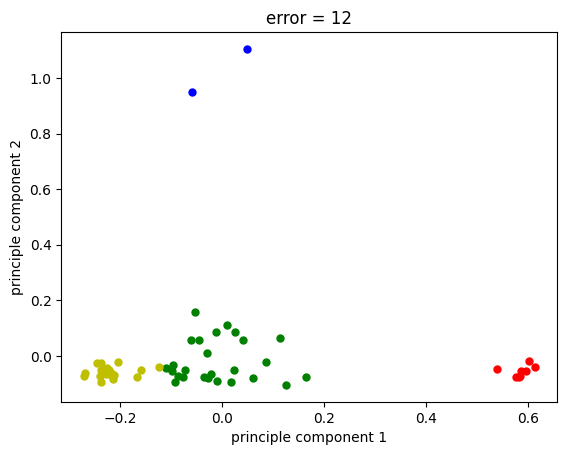

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[26  8  2 20]


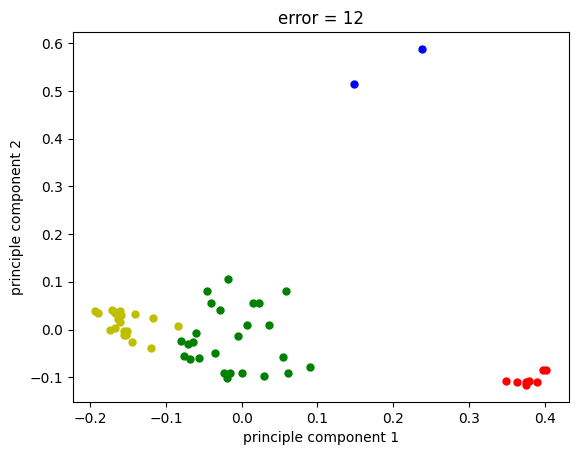

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[22  8  2 24]


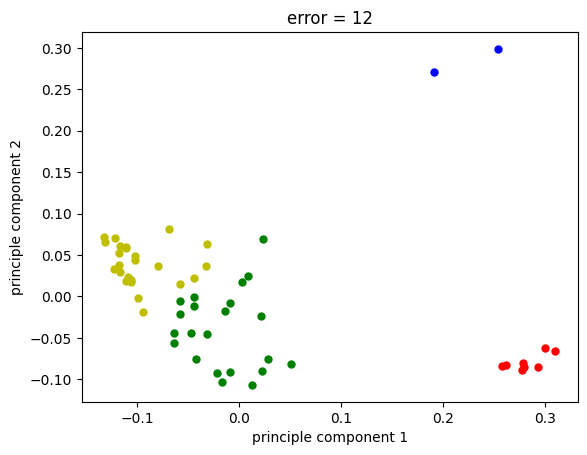

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[10 21  6 19]


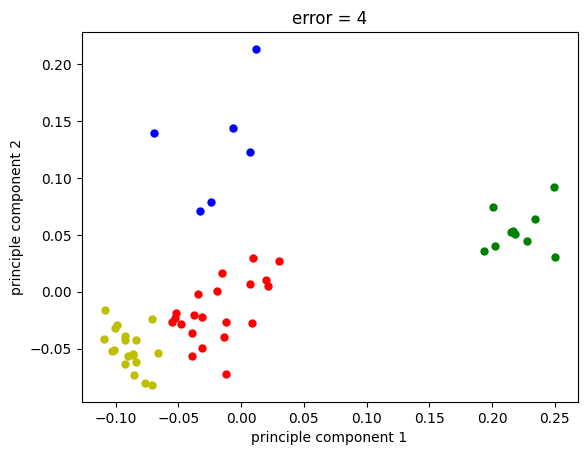

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[15 10 25  6]


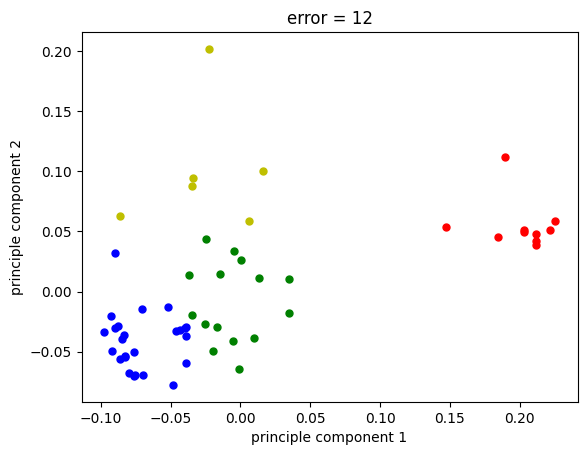

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[ 8 10 20 18]


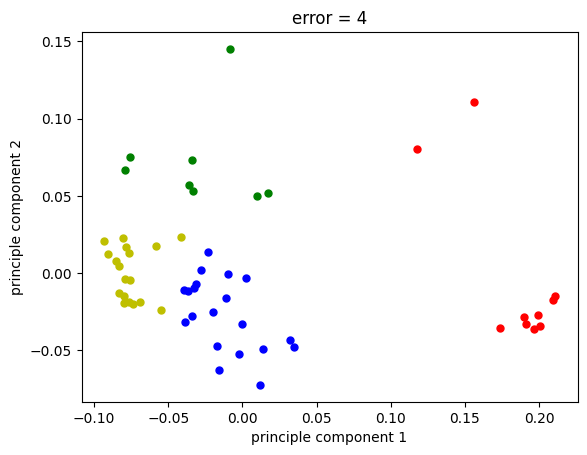

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[25 11 15  5]


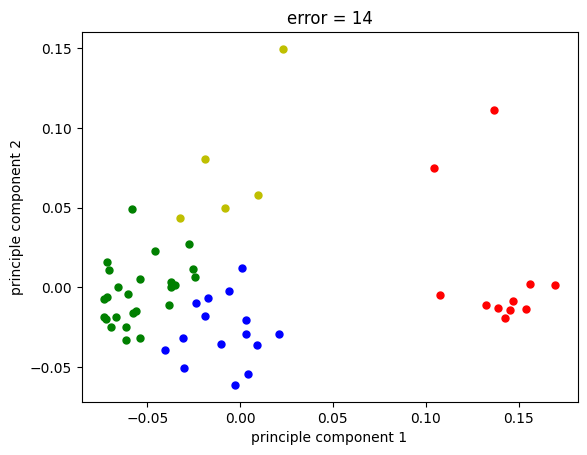

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[15 11  5 25]


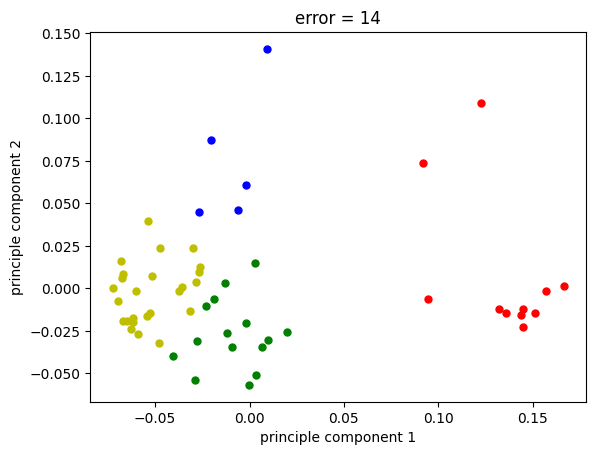

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[23  9 20  4]


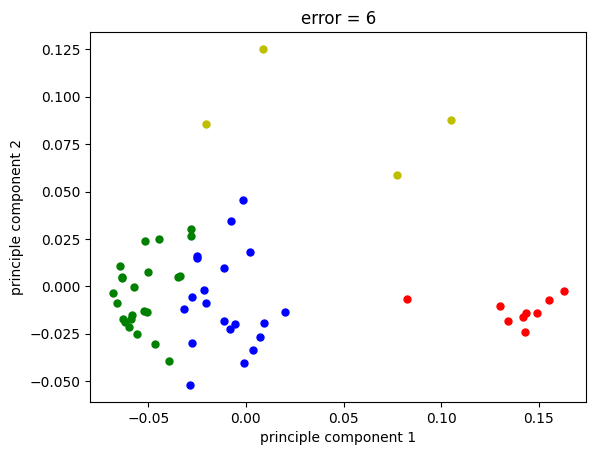

final division 4


In [ ]:
file_path = '/content/drive/MyDrive/Research/Bioinformatics/scRNAseq/datas/biase_data.csv'

min_error = +100000000
final_division = -1
file_name = "biase_datas"

# exploring different division on data
for i in range(1, 10, 1):

  df = Read_File(file_path).readFileRetDF()
  fTune = FineTune(df)
  ground_truth = [7, 9, 20, 20]

  km = KMEANS(fTune, ground_truth)
  km.performKmeans(number_of_division = i, n_components = 2, n_clusters = 4)
  km.plot(file_name)

  if(km.error < min_error):
      min_error = km.error
      final_division = i

print("final division", final_division)


/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


0 1666
1666 3332
3332 4998
4998 6664
6664 8330
8330 9996
6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


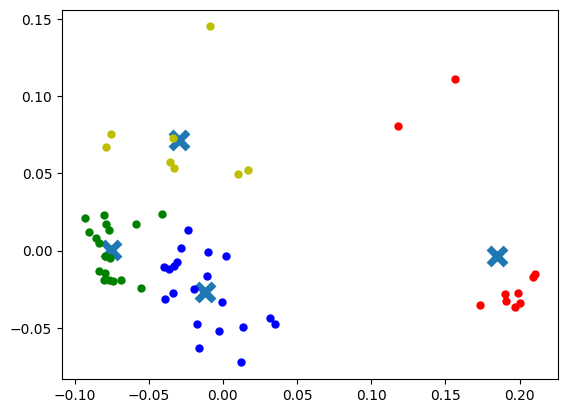

[18 10 20  8]


In [ ]:
file_path = '/content/drive/MyDrive/Research/Bioinformatics/scRNAseq/datas/biase_data.csv'
df = Read_File(file_path).readFileRetDF()


fTune = FineTune(df)
# pca_features = fTune.performAllTuning(n_components = 2)

# pca_features1, pca_features2, pca_features3, pca_features4 = fTune.performAllTuning4(n_components = 2)

number_of_division = 6
pca_features_all = fTune.performAllTuning4(n_components = 2, number_of_division = number_of_division)
print(len(pca_features_all))


pca_features_final = pca_features_all[number_of_division - 1]
for i in range(number_of_division - 1):
    pca_features_final = pca_features_final + pca_features_all[i]

pca_features_final = pca_features_final / number_of_division

X = pca_features_final

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

#get the centroids
centroids = kmeans.cluster_centers_
labels = kmeans.labels_


#plot the data points with associated centroids
colors = ["g.", "r.", "b.", "y."]
for i in range(len(X)):
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize=10)
plt.scatter(centroids[:,0], centroids[:,1], marker='x', s=150, linewidths=5)
plt.show()


print(np.bincount(labels))

# pca_features_final = (pca_features1 + pca_features2 + pca_features3 + pca_features4) / 4

In [ ]:
type(pca_features_all[0])

numpy.ndarray

In [ ]:
pca_features_final

array([[ 2.15194624e-01,  5.25048963e-02],
       [ 2.27665472e-01,  4.43261353e-02],
       [ 2.02656252e-01,  4.03108660e-02],
       [ 2.18447686e-01,  5.05126999e-02],
       [ 2.16398802e-01,  5.32297005e-02],
       [ 2.00615717e-01,  7.41622940e-02],
       [ 7.10655002e-03,  1.23146928e-01],
       [ 2.50217886e-01,  3.09053141e-02],
       [ 2.34393460e-01,  6.37923000e-02],
       [-3.78491041e-02, -2.08253906e-02],
       [-3.91921922e-02, -3.61545719e-02],
       [-4.82652953e-02, -2.88104139e-02],
       [-1.88661961e-02,  2.25588309e-04],
       [-7.10418352e-02, -2.39601390e-02],
       [-5.15343515e-02, -1.84832473e-02],
       [-1.55452528e-02,  1.62158714e-02],
       [ 1.17341162e-02,  2.13509505e-01],
       [-5.53763526e-02, -2.62803374e-02],
       [-3.10356306e-02, -2.21881324e-02],
       [ 9.85502197e-03,  2.97608140e-02],
       [ 3.04042861e-02,  2.71519311e-02],
       [ 1.99533982e-02,  1.00028058e-02],
       [ 2.17596768e-02,  5.21195873e-03],
       [ 7.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


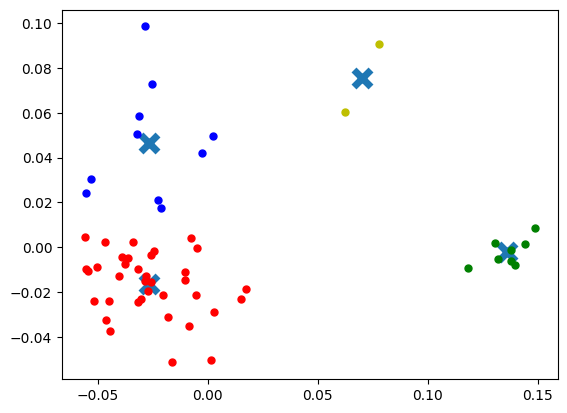

[ 8 36 10  2]


In [ ]:

X = pca_features_final

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

#get the centroids
centroids = kmeans.cluster_centers_
labels = kmeans.labels_


#plot the data points with associated centroids
colors = ["g.", "r.", "b.", "y."]
for i in range(len(X)):
    plt.plot(X[i][0], X[i][1], colors[labels[i]], markersize=10)
plt.scatter(centroids[:,0], centroids[:,1], marker='x', s=150, linewidths=5)
plt.show()


print(np.bincount(labels))

**GNN**

In [ ]:
class Main:
    def main(self):
        file_path = '/content/drive/MyDrive/Research/Bioinformatics/scRNAseq/datas/biase_data.csv'
        df = Read_File(file_path).readFileRetDF()


        fTune = FineTune(df)
        pca_features = fTune.performAllTuning(n_components = 2)


        # df = FineTune().makeCellByGeneFile(df = df)
        # df = FineTune().normalize(df)
        # df = FineTune().findHVG(df)
        # pca_features = FineTune().PCA(df = df, n_components = 2)

        Plot().scatterplotPCA(pca_features)

        g = constructGraph(node_feats = fTune.df, pca_features = pca_features)

        # g = Graph(node_feats = fTune.df)
        # g.setEdgeIndexAndWeight(pca_features = pca_features)


        num_nodes = g.numberOfNodes()
        num_features = g.numberOfFeats()
        hidden_dim = 16
        num_clusters = 4

        print(type(g.node_feats))

        g.convertToTensorObj()

        # # # edge_index = torch.tensor(g.edge_index)  # Edge indices
        # # # edge_weight = torch.tensor(g.edge_weight)  # Edge weights
        # # # # node_feats1 = torch.randn(num_nodes, num_features)
        # # # node_feats = torch.tensor(g.node_feats.values).float()

        # # # Example usage:
        # # # Let's assume 'data' is a PyTorch-Geometric data object with 'x' as node features and 'edge_index' as graph connectivity
        model = GNN(num_node_features=num_features, num_clusters=num_clusters, hidden_dim = hidden_dim)
        # e = Execute(model, g);
        # out = e.runModel()
        out = model(g)
        # print(out)


        Plot().scatterPlot(pca_features, out)

        return model, g, pca_features

/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/usr/local/lib/python3.10/dist-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


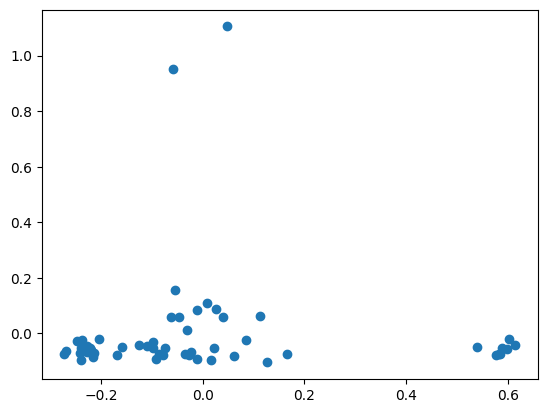

<class 'pandas.core.frame.DataFrame'>


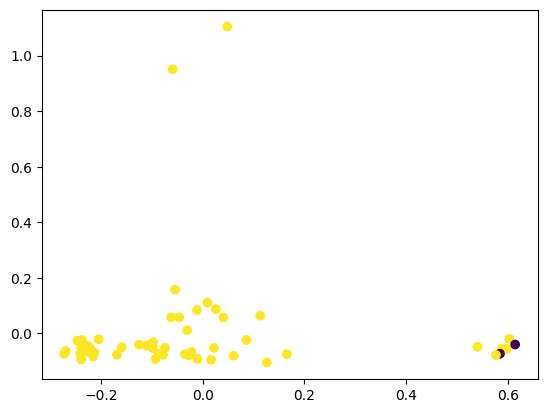

In [ ]:
model, g, pca_features = Main().main()

In [ ]:
out = model(g)
lis = list(model.parameters())
lis

[Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0162,  0.0214, -0.0110,  ...,  0.0091,  0.0180,  0.0137],
         [ 0.0111, -0.0112,  0.0019,  ...,  0.0221,  0.0085, -0.0046],
         [ 0.0136, -0.0040,  0.0189,  ...,  0.0041,  0.0222,  0.0239],
         ...,
         [-0.0154,  0.0088,  0.0073,  ...,  0.0132,  0.0153, -0.0109],
         [-0.0013,  0.0071,  0.0073,  ...,  0.0156, -0.0184,  0.0042],
         [ 0.0128, -0.0099, -0.0195,  ..., -0.0211,  0.0157,  0.0212]],
        requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1466,  0.0493,  0.2069,  0.4483,  0.5539, -0.4915,  0.5435, -0.3742,
          -0.5586, -0.3064, -0.2667, -0.0338, -0.4529,  0.0144,  0.1662,  0.0050],
         [-0.1871, -0.0706,  0.5056,  0.4050,  0.0842, -0.4095,  0.4656, -0.0211,
          -0.3144,  0.2571, -0.2496, -0.1194,

In [ ]:
out = model(g)
lis = list(model.parameters())
lis

[Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0162,  0.0214, -0.0110,  ...,  0.0091,  0.0180,  0.0137],
         [ 0.0111, -0.0112,  0.0019,  ...,  0.0221,  0.0085, -0.0046],
         [ 0.0136, -0.0040,  0.0189,  ...,  0.0041,  0.0222,  0.0239],
         ...,
         [-0.0154,  0.0088,  0.0073,  ...,  0.0132,  0.0153, -0.0109],
         [-0.0013,  0.0071,  0.0073,  ...,  0.0156, -0.0184,  0.0042],
         [ 0.0128, -0.0099, -0.0195,  ..., -0.0211,  0.0157,  0.0212]],
        requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1466,  0.0493,  0.2069,  0.4483,  0.5539, -0.4915,  0.5435, -0.3742,
          -0.5586, -0.3064, -0.2667, -0.0338, -0.4529,  0.0144,  0.1662,  0.0050],
         [-0.1871, -0.0706,  0.5056,  0.4050,  0.0842, -0.4095,  0.4656, -0.0211,
          -0.3144,  0.2571, -0.2496, -0.1194,

In [ ]:
out = model(g)
out = model(g)
out = model(g)
out = model(g)
out = model(g)
lis = list(model.parameters())
lis

[Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0162,  0.0214, -0.0110,  ...,  0.0091,  0.0180,  0.0137],
         [ 0.0111, -0.0112,  0.0019,  ...,  0.0221,  0.0085, -0.0046],
         [ 0.0136, -0.0040,  0.0189,  ...,  0.0041,  0.0222,  0.0239],
         ...,
         [-0.0154,  0.0088,  0.0073,  ...,  0.0132,  0.0153, -0.0109],
         [-0.0013,  0.0071,  0.0073,  ...,  0.0156, -0.0184,  0.0042],
         [ 0.0128, -0.0099, -0.0195,  ..., -0.0211,  0.0157,  0.0212]],
        requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0.], requires_grad=True),
 Parameter containing:
 tensor([[ 0.1466,  0.0493,  0.2069,  0.4483,  0.5539, -0.4915,  0.5435, -0.3742,
          -0.5586, -0.3064, -0.2667, -0.0338, -0.4529,  0.0144,  0.1662,  0.0050],
         [-0.1871, -0.0706,  0.5056,  0.4050,  0.0842, -0.4095,  0.4656, -0.0211,
          -0.3144,  0.2571, -0.2496, -0.1194,

In [ ]:
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# criterion = nn.CrossEntropyLoss()

In [ ]:
# def train(model, g):
#     model.train()
#     optimizer.zero_grad()
#     out = model(g)  # Forward pass
#     loss = criterion(out, data.y)  # Compute loss
#     loss.backward()  # Backpropagation
#     optimizer.step()  # Update model parameters
#     return loss.item()

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.DataFrame(g.node_feats)

In [ ]:

n_input_layer = df.shape[1]
n_encoding_layer = 1
n_output_layer = n_input_layer


autoencoder = tf.keras.models.Sequential([
    # ENCODER
    tf.keras.layers.Dense(n_input_layer, input_shape=(n_input_layer,), activation='elu'),
    # CENTRAL LAYER
    tf.keras.layers.Dense(n_encoding_layer, activation='elu', name='central_layer'),
    # DECODER
    tf.keras.layers.Dense(n_output_layer, activation='elu')
])

In [ ]:
n_epochs = 5
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001, clipvalue=0.5)
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_history = []

In [ ]:
# def train(model, g):
#     model.train()
#     optimizer.zero_grad()
#     out = model(g)  # Forward pass
#     loss = criterion(out, data.y)  # Compute loss
#     loss.backward()  # Backpropagation
#     optimizer.step()  # Update model parameters
#     return loss.item()

In [ ]:
out = model(g)
val = 1

In [ ]:


for epoch in range(1):
    with tf.GradientTape() as tape:
        model.train()
        # optimizer.zero_grad()
        out = model(g)
        current_loss = loss(autoencoder(df.values), df.values)
        # gradients = tape.gradient(current_loss, autoencoder.trainable_variables)
        # optimizer.step()
        gradients = tape.gradient(current_loss, autoencoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
        loss_history.append(current_loss.numpy())

    # Show loss improvement every 200 epochs

    print(f"{epoch + 1}. Loss: {current_loss.numpy()} . Out: {out[0:1][0][0]}")
    print(f"{list(model.parameters())}")

1. Loss: 6.090831084293313e-05 . Out: -1.0940124988555908
[Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       requires_grad=True), Parameter containing:
tensor([[-0.0162,  0.0214, -0.0110,  ...,  0.0091,  0.0180,  0.0137],
        [ 0.0111, -0.0112,  0.0019,  ...,  0.0221,  0.0085, -0.0046],
        [ 0.0136, -0.0040,  0.0189,  ...,  0.0041,  0.0222,  0.0239],
        ...,
        [-0.0154,  0.0088,  0.0073,  ...,  0.0132,  0.0153, -0.0109],
        [-0.0013,  0.0071,  0.0073,  ...,  0.0156, -0.0184,  0.0042],
        [ 0.0128, -0.0099, -0.0195,  ..., -0.0211,  0.0157,  0.0212]],
       requires_grad=True), Parameter containing:
tensor([0., 0., 0.], requires_grad=True), Parameter containing:
tensor([[ 0.1466,  0.0493,  0.2069,  0.4483,  0.5539, -0.4915,  0.5435, -0.3742,
         -0.5586, -0.3064, -0.2667, -0.0338, -0.4529,  0.0144,  0.1662,  0.0050],
        [-0.1871, -0.0706,  0.5056,  0.4050,  0.0842, -0.4095,  0.4656, -0.0211,
    

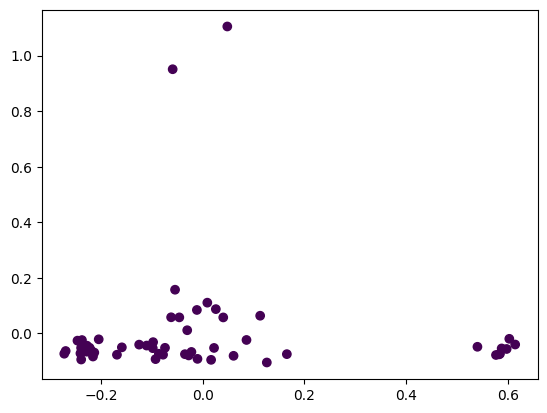

In [ ]:
Plot().scatterPlot(pca_features, out)

In [ ]:
#@title Loss calculation by reconstruction(encoder + decoder) code for unsupervised case


import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

# Generate some random data (replace with your own dataset)
data = np.random.randint(1, 100, 500)
df = pd.DataFrame({'f1': data, 'f2': data**2, 'f3': data * 0.33, 'f4': data / 20})
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_df, columns=['f1', 'f2', 'f3', 'f4'])

# Define the autoencoder architecture
n_input_layer = scaled_df.shape[1]
n_encoding_layer = 1
n_output_layer = n_input_layer

autoencoder = tf.keras.models.Sequential([
    # ENCODER
    tf.keras.layers.Dense(n_input_layer, input_shape=(n_input_layer,), activation='elu'),
    # CENTRAL LAYER
    tf.keras.layers.Dense(n_encoding_layer, activation='elu', name='central_layer'),
    # DECODER
    tf.keras.layers.Dense(n_output_layer, activation='elu')
])

# Training parameters
n_epochs = 5000
loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001, clipvalue=0.5)
loss_history = []

# Training loop


# The loss_history list contains loss values over epochs
for epoch in range(2):
    with tf.GradientTape() as tape:
        current_loss = loss(autoencoder(scaled_df.values), scaled_df.values)
        gradients = tape.gradient(current_loss, autoencoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
        loss_history.append(current_loss.numpy())

    # Show loss improvement every 200 epochs
    if (epoch + 1) % 200 == 0:
        print(f"{epoch + 1}. Loss: {current_loss.numpy()}")
